<a href="https://colab.research.google.com/github/cafalchio/place_cells_analysis/blob/main/phd_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Place cells analysis**

**mount gdrive (data)** 

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**install neurochat**

In [10]:
!pip install git+https://github.com/seankmartin/NeuroChaT -q

**importing libraries**

In [26]:
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from neurochat.nc_datacontainer import NDataContainer
from neurochat.nc_spatial import NSpatial
import neurochat.nc_containeranalysis as nca
from neurochat.nc_control import NeuroChaT
import neurochat.nc_plot as nc_plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Cosiderations:**


For this paper we will need the main place field analyses: 

1. **location or center of mass** (it will tell us about the place remapping), 

2. **peak firing** (it will tell us about the rate remapping).

3. **PSTH** 0.05 seconds before/after the pulse. (it will tell us which cell responds to the stimulation);

4. **place field size** 

5. **number of place fields**.

##### **Definitions:**

*   place field defined as at least 3 neighbor bins
*   bin_size defined as 3 camera pixels
*   bins with less than 10% the peak firing of the place field were not included
*   place fields were calculated from the raw firing map (time bins / firing bins)




##### **To be be improved:**

*   define pyramidal cells based on waveform and firing rate
*   define place field based on sparsity, skaggs and spatial correlation



##### **ATTENTION:**

*   Because place cells were defined as at least 3 neighbors bins. It can result in too many place cells in some files. There is a tradeoff between bin size and number of pixels that can be adjusted for get meaninful results.
*   There is no discrimination between interneurons and place cells, so the code will try to find place cells based on the definitions, but it will not be correct for interneurons.
*   When no place field is detected, the centre of mass is by default the centre of the total firing rate, tending to appears on the middle of the arena.

#### **Config and run**

In [36]:
#CONFIG FOLDER AND PLOT
path_dir = "/content/gdrive/MyDrive/Crossword maze data/"
rat = 'MSL17'
main_dir = path_dir+rat
plot_cells = True ## Will plot all the cells in a subfolder of the data
dpi = 150
#["Wave", "Path", "Place", "HD", "LowAC", "Theta", "HighISI"]# What to plot
plot_output = ['Wave', 'Path', 'Place'] 
#Place field config
bin_size = 3 # how big a bin is in cm
min_place_field_neighbours = 3
filter_ = ("b", 3)
# exclude bins with less than 10% of peak firing from place field
firing_rate_needed_for_place_field = 0.1
# If neurochat cutting away data set chop_bound to 0
chop_bound = 0
# Calculates place field after smoothing if True
smooth_place = False
kwargs = {
    "pixel": bin_size,
    "chop_bound": chop_bound,
    "filter": filter_,
    "fieldThresh": firing_rate_needed_for_place_field,
    "minPlaceFieldNeighbours": min_place_field_neighbours,
    "smoothPlace": smooth_place,
}

##### **Properties to be saved**

In [37]:
DEBUG = False

# Results to be stored:
results = {
    "file": [], #Filename
    "tetrode": [], # Tetrode number
    "cell": [], # Cell number
    "field_number": [], # Number of place field analysed
    "centre_x": [], # centre of mass, cord x in cm
    "centre_y": [], # centre of mass, cord y in cm
    "pf_size" : [], # place field size in bins units
    "pf_n_spks": [],# number of spikes in the place field
    "pf_peak_frate": [] # place field peak firing rate
  }

##### **Find and run all files from base path**

ERROR:root:Occurred during place cell summary on data 2 unit 7 name 170118a-MSL17-bigmaze.10 in /content/gdrive/MyDrive/Crossword maze data/MSL17 failed with caught exception.
See /root/.nc_saved/nc_caught.txt for more information.
ERROR:root:Occurred during place cell summary on data 3 unit 1 name 170118a-MSL17-bigmaze.10 in /content/gdrive/MyDrive/Crossword maze data/MSL17 failed with caught exception.
See /root/.nc_saved/nc_caught.txt for more information.


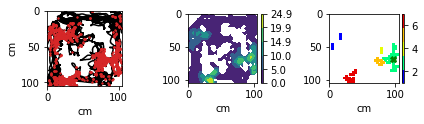

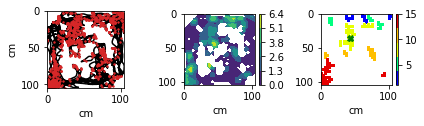

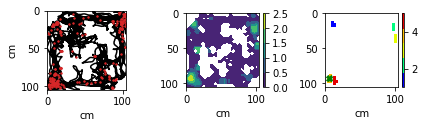

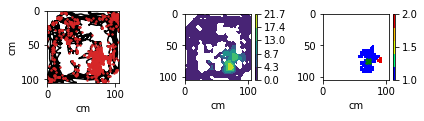

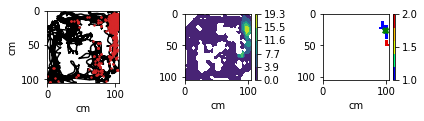

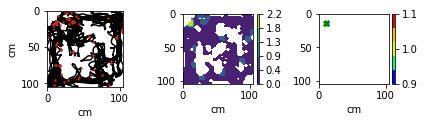

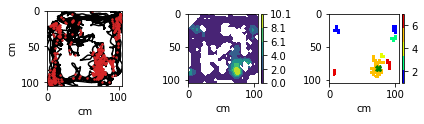

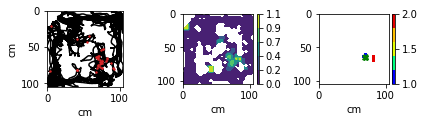

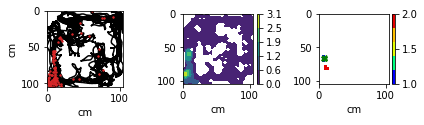

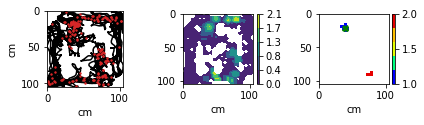

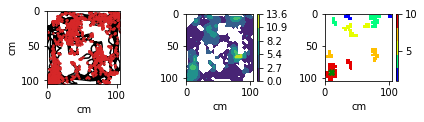

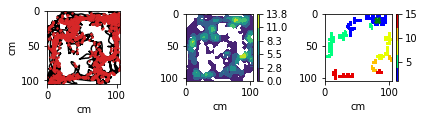

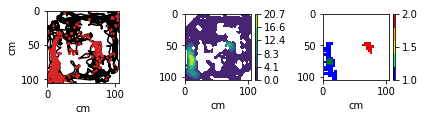

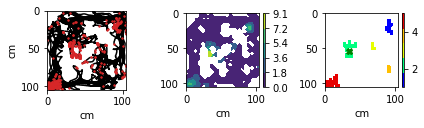

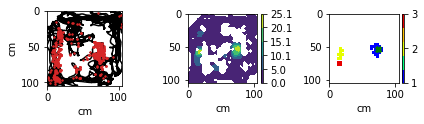

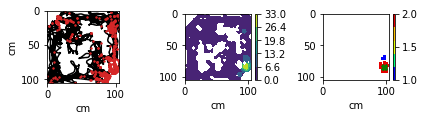

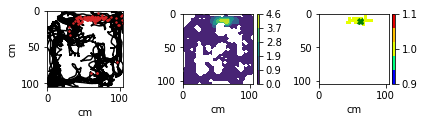

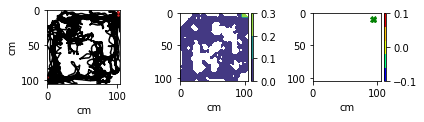

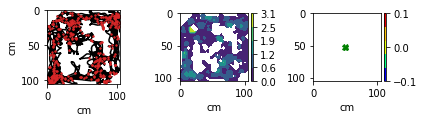

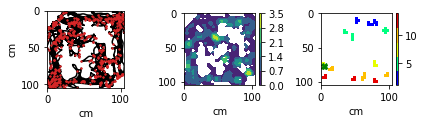

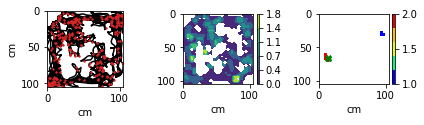

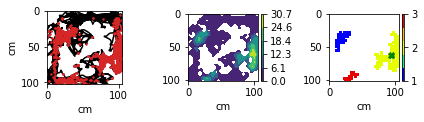

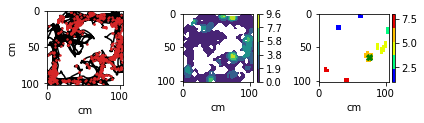

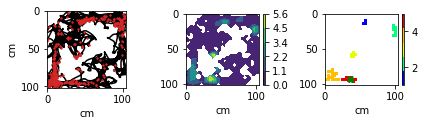

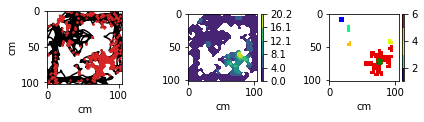

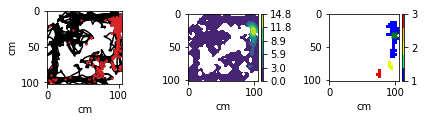

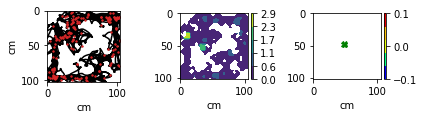

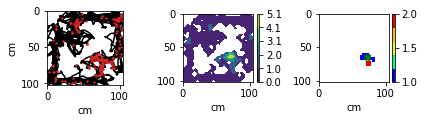

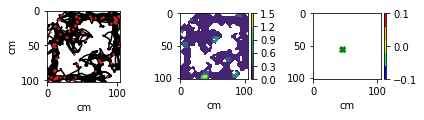

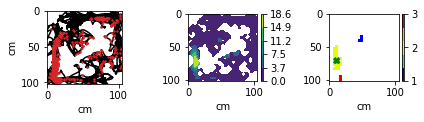

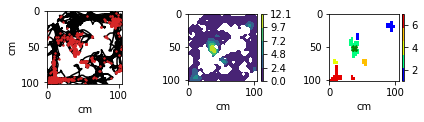

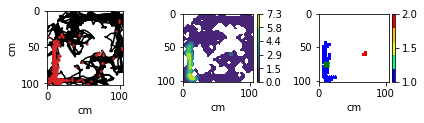

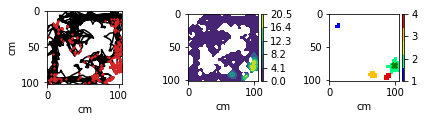

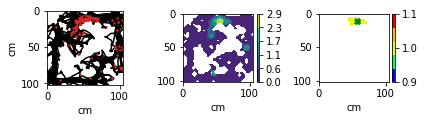

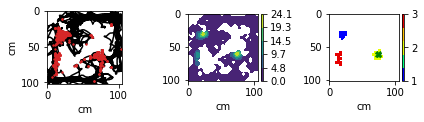

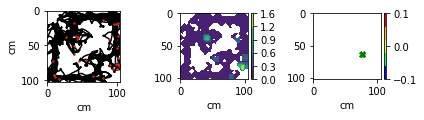

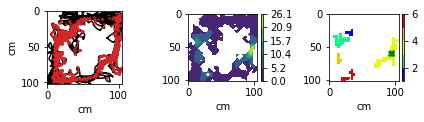

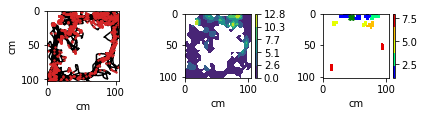

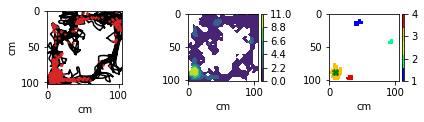

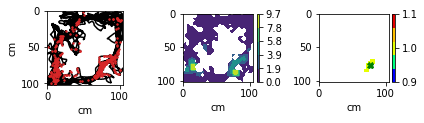

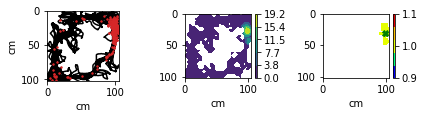

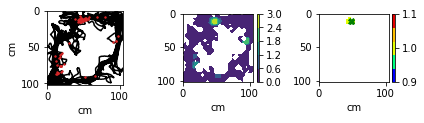

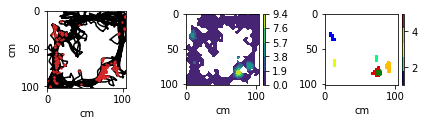

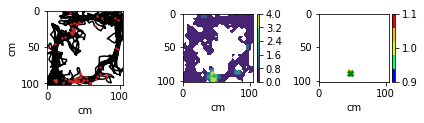

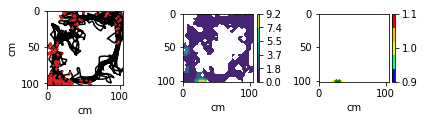

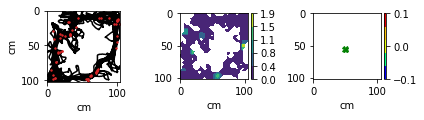

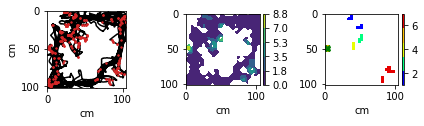

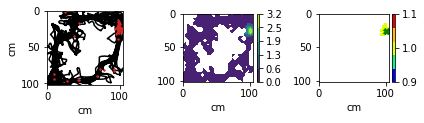

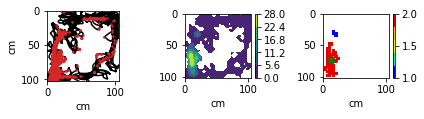

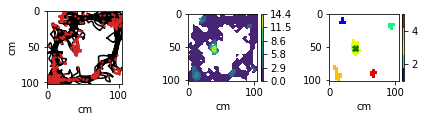

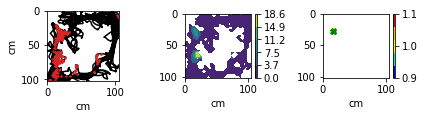

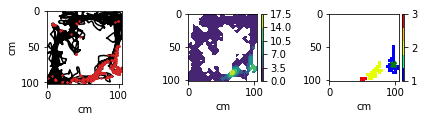

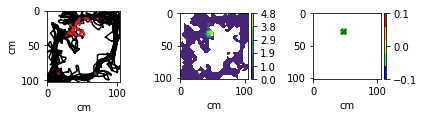

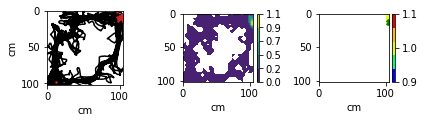

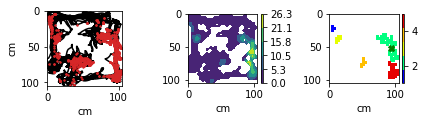

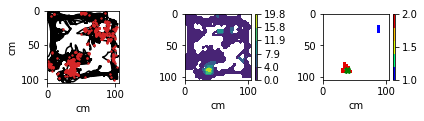

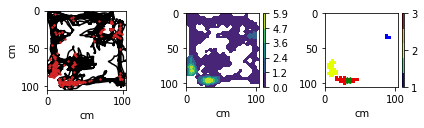

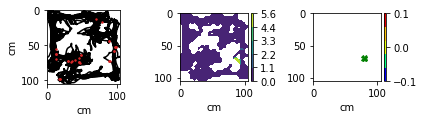

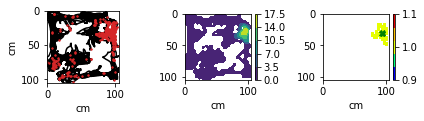

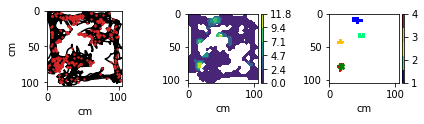

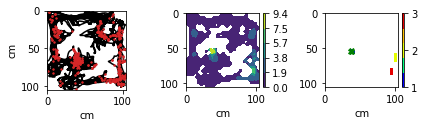

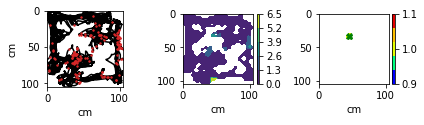

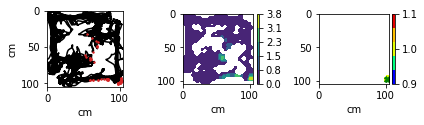

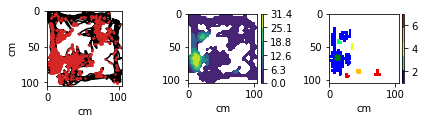

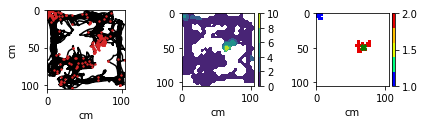

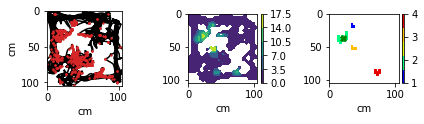

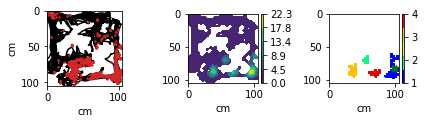

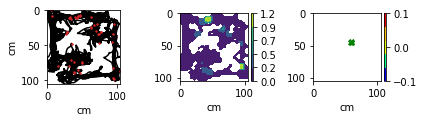

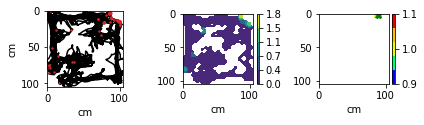

In [38]:
# Run all files
container = NDataContainer(load_on_fly=True)
container.add_axona_files_from_dir(main_dir, recursive=True, verbose=False)
container.setup()
if plot_cells:
    nca.place_cell_summary(container, output=plot_output, dpi=dpi, out_dirname="plot_cells")
    
for i, data in enumerate(container):
    data_idx, unit_idx = container._index_to_data_pos(i)
    filename = container.get_file_dict()["Spike"][data_idx][0]
    result_file, tetrode_number = container.get_file_dict()["Spike"][data_idx][0].split('/')[-1].split('.')
    unit_number = container.get_units(data_idx)[unit_idx]
    spike_times = data.spike.get_timestamp(unit_number)
    place_data = data.place(**kwargs)
    bin_area = bin_size
    f_dir = os.path.dirname(filename)
    data_basename = (result_file + "_" + tetrode_number + "_" +
                            str(unit_number) + ".jpg")
    # Firing map stuff
    firing_map = place_data["firingMap"]
    smoothed_firing_map = place_data["smoothMap"]

    # Place field stuff
    largest_place_field_number = place_data["largestPlaceGroup"]
    place_fields = place_data["placeField"]

    # print(f'{result_file} - tet: {tetrode_number} - unit: {unit_number}')
    # fig, axes = plt.subplots(1, 3)
    # # 1 Firing map
    # axes[0].imshow(firing_map)
    # axes[0].set_title("Firing Map")

    # # 2 Smooth map
    # axes[1].imshow(smoothed_firing_map)
    # axes[1].set_title("Smooth Firing Map")

    # # 3 Place field
    # axes[2].imshow(place_fields)
    # axes[2].set_title("Place fields")
    # plt.show()
    # plt.close()
    ax = nc_plot.loc_firing_and_place(place_data)
    plt.savefig(f_dir+'/'+'nc_results'+'/'+data_basename, dpi=75)
    plt.show()
    plt.close()
    #Assume more than one place field
    tmap = place_data["tmap"]
    # How many place fields
    num_place_fields = np.unique(place_fields).size - 1
    # num_place_fields = 1
    # print(f"num_place_fields: {num_place_fields}")
    place_field_results = {}
    if smooth_place:
        pmap = smoothed_firing_map
    else:
        pmap = firing_map
    pmap[tmap == 0] = None
    spike_counts = place_data["spikeCounts"].astype(int)
        
    for i in range(1, num_place_fields + 1):
        centroid = NSpatial.place_field_centroid(place_fields, pmap, i)
        centroid = centroid * bin_size + (bin_size * 0.5)
        # flip x and y
        centroid = centroid[::-1]
        bins_in_place_field = np.array(np.where(place_fields == i))     
        place_field_size = bins_in_place_field.size
        # Our own code - TODO update NC
        spike_counts_place_field = spike_counts[
            bins_in_place_field[0], bins_in_place_field[1]]
        number_of_spikes_in_place_field = np.sum(spike_counts_place_field)
        max_firing_rate_in_place_field = pmap[
            bins_in_place_field[0], bins_in_place_field[1]].max()
        #Log results
        results["file"].append(result_file) 
        results["tetrode"].append(tetrode_number)
        results["cell"].append(unit_number)
        results["field_number"].append(i)
        results["centre_x"].append(centroid[0]) 
        results["centre_y"].append(centroid[1])
        results["pf_size"].append(place_field_size) 
        results["pf_n_spks"].append(number_of_spikes_in_place_field)
        results["pf_peak_frate"].append(max_firing_rate_in_place_field)
    if DEBUG and i>=10:
      break 
##Save results
df = pd.DataFrame(results)
df.to_csv(f'{f_dir}/nc_results/{rat}_results.csv', index=False)

In [39]:
df

,file,tetrode,cell,field_number,centre_x,centre_y,pf_size,pf_n_spks,pf_peak_frate
0,170118a-MSL17-bigmaze,1,1,1,16.500000,34.798528,6,92,13.563830
1,170118a-MSL17-bigmaze,1,1,2,4.500000,49.269231,6,7,25.000000
2,170118a-MSL17-bigmaze,1,1,3,96.233292,68.013502,72,436,37.837838
3,170118a-MSL17-bigmaze,1,1,4,79.500000,54.710526,6,9,30.000000
4,170118a-MSL17-bigmaze,1,1,5,77.292159,72.400258,20,158,42.857143
...,...,...,...,...,...,...,...,...,...
227,170118-MSL17-probe-bigmaze,10,4,1,97.757811,81.734714,80,357,50.000000
228,170118-MSL17-probe-bigmaze,10,4,2,56.999142,69.927373,16,99,23.684211
229,170118-MSL17-probe-bigmaze,10,4,3,37.476481,86.928212,38,248,25.925926
230,170118-MSL17-probe-bigmaze,10,4,4,68.696139,88.827197,26,75,37.500000
